# Video processing

     Load video frames
     Shrink resolution
     Perform KMeans classification for each frame.
     Calculate percent wrinkle for each frame
     Save movie of wrinkle
     Generate plotly plot of percent wrinkle over time
     Include it in functions.py


In [1]:
# Python packages
import os, urllib, io, math, cv2, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
import scipy.misc
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

### Load Video frames

In [2]:
cap         = cv2.VideoCapture('video/PA14 phzmutant.mov')
frameCount  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
X           = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))
fc          = 0
ret         = True

while (fc < frameCount  and ret):
    ret, X[fc] = cap.read()
    fc += 1

# cap.release()

# cv2.namedWindow('frame 10')
# cv2.imshow('frame 10', X[9])

# # cv2.waitKey(0)



In [15]:
len(np.arange(0, frameCount, int(281/20))[:20])

20

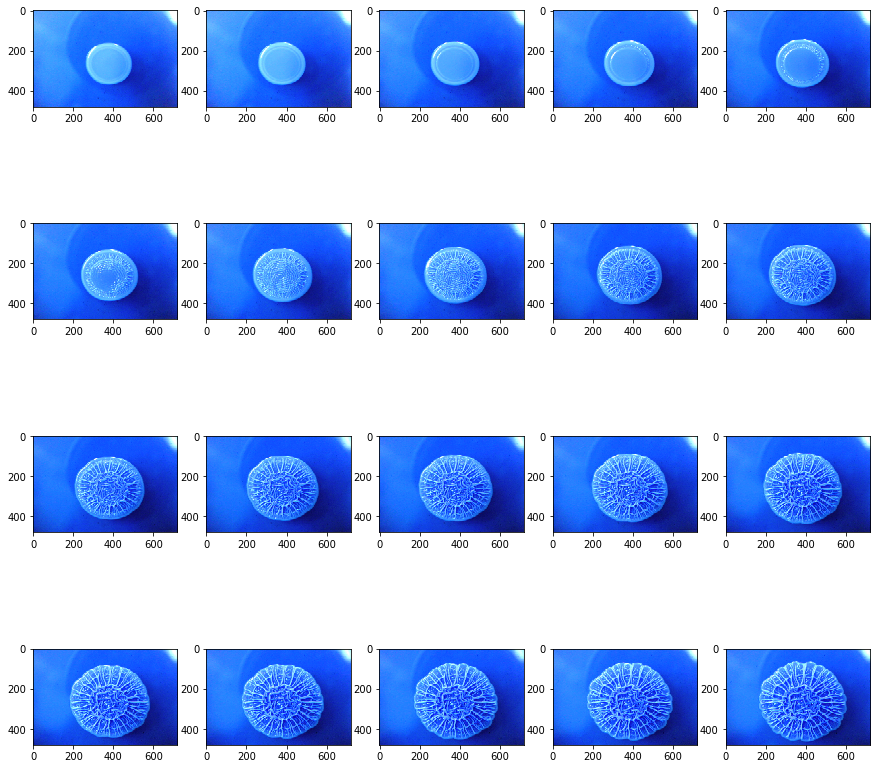

In [17]:
# Print sample frames
# for frame in np.arange(0, frameCount, 50):
# #     t = cv2.resize(X[frame], dsize=dsize, interpolation=cv2.INTER_CUBIC)
#     plt.imshow(X[frame])
#     plt.show()
    
    
frames = np.arange(0, frameCount, int(281/20))[:20]
f, axarr = plt.subplots(4, 5, figsize=(15,15))
k=0
for i in range(4):
    for j in range(5):
        axarr[i,j].imshow(X[frames[k]])
        k+=1
        
plt.savefig('biofilm_over_time.png')

### Resize and reshape

    Resize for faster training
    Reshape for KMeans

In [29]:
# Variables

# New X
# X_resize  = np.resize(X, size)
# X_reshape = np.reshape(X_resize, (len(X), -1, 3))

### Apply KMeans model 

In [18]:
def get_classes(img, resize=128, n_clusters=7, movie=False):
    
    # Resize
    if not movie:
        size             = (resize, resize)
        img_resize       = img.resize(size, Image.ANTIALIAS)#resize
        img_array_resize = np.asarray(img_resize)
    else:
        reduce_factor    = 4
        size             = tuple(np.divide(img.shape[:2], reduce_factor).astype(int)) + (3,)
        img_array_resize = np.resize(img, size)

    
    # Reshape
    w,h,d = tuple(img_array_resize.shape)
    X  = np.reshape(img_array_resize, (w*h,d))
    km = KMeans(n_clusters=n_clusters, random_state=0)
    km.fit(X)
    
    img_array=np.asarray(img)
    w,h,d = tuple(img_array.shape)
    labels=km.predict(np.reshape(img_array, (w*h, d)))
    classes = np.reshape(labels, img_array.shape[:2]) 
    classes = np.multiply(classes, 255.0/np.max(classes)) # Normalize
    
    return(labels,classes)



In [19]:
def plot_wrinkle_class(img_wrinkle_class, save=True):
    plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(img_wrinkle_class)

    if save:
        pylab.savefig('static/results/wrinkle.png',bbox_inches='tight')


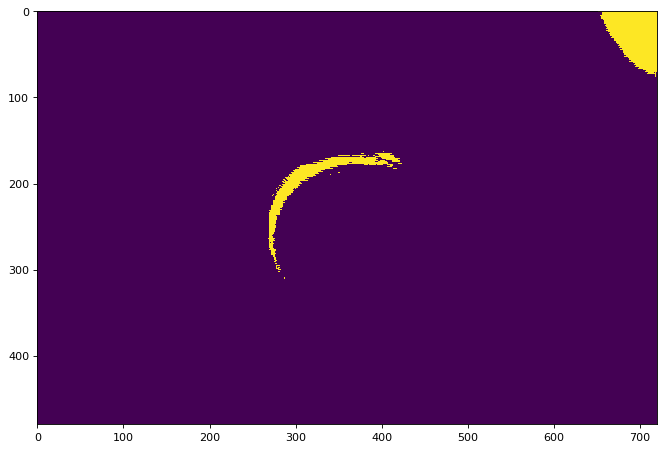

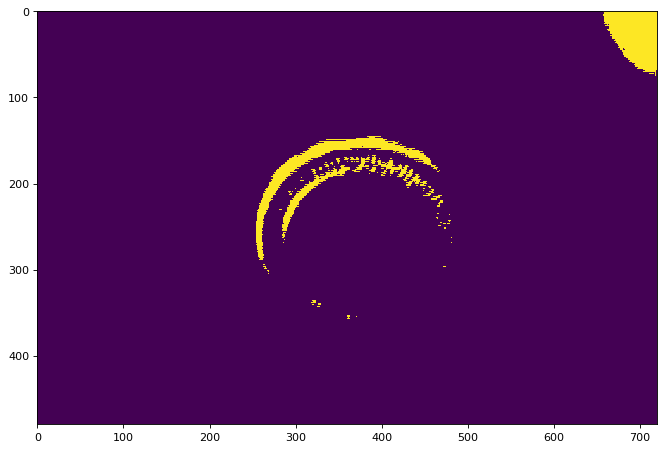

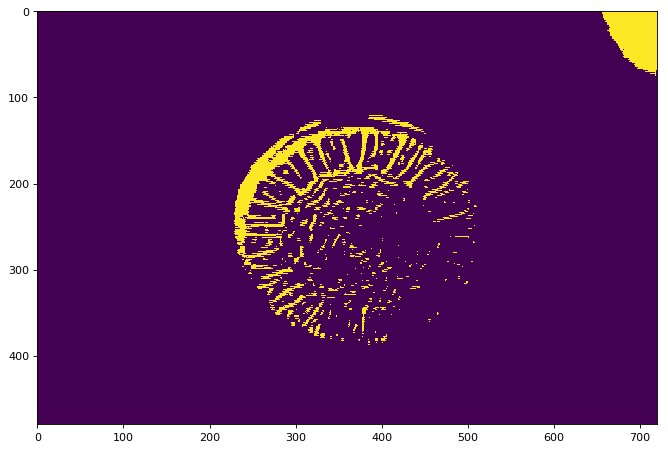

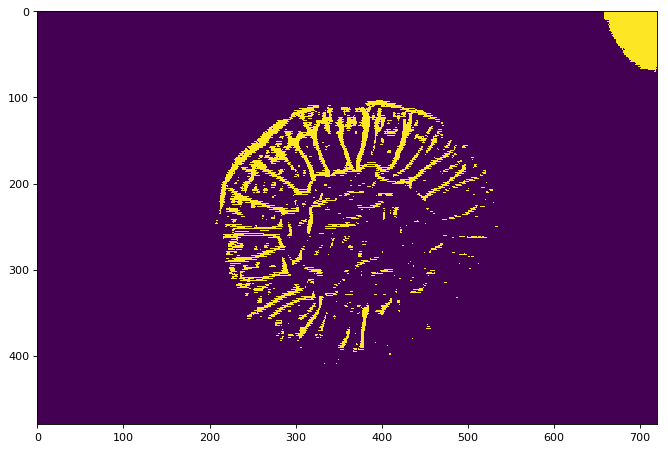

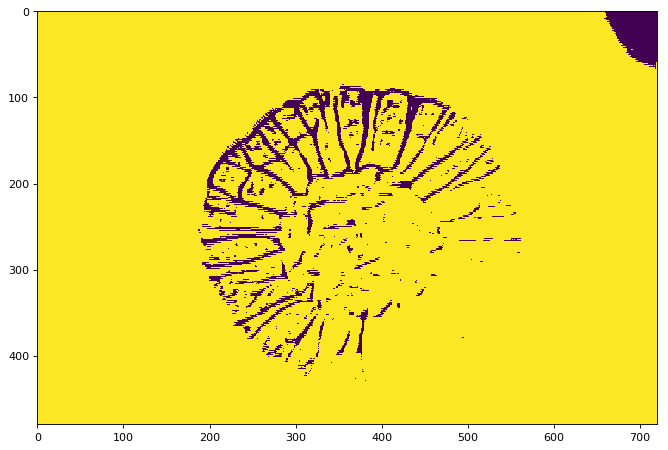

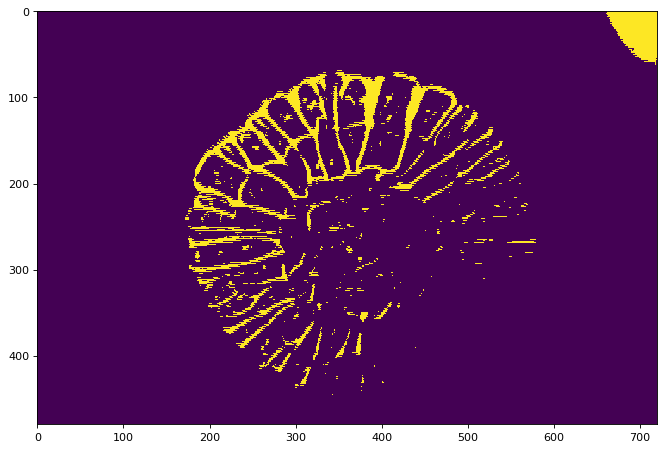

In [20]:
# Run on each frame and calculate percent wrinkle
percent_wrinkle = np.array([])
i = 1

for frame in np.arange(0, frameCount, 1):
    # Classification model
    labels, classes = get_classes(X[frame], n_clusters = 2, movie=True)
    
    # Add to array
    temp = np.reshape(classes, (-1, classes.shape[0], classes.shape[1]))
    if frame == 0:
        movie_new = temp
    else:
        movie_new = np.vstack((movie_new, temp))
        
    # Calculate percent wrinkle
    bin_count       = np.bincount(labels)
    wrinkle         = min(bin_count) / np.sum(bin_count)
    percent_wrinkle = np.append(percent_wrinkle, wrinkle)
    
    # Save frames to file
    cv2.imwrite("video/frames/frame%d.jpg" % i, classes)
    
    # Plot every thirty frames
    if frame%50 == 0:
        plot_wrinkle_class(classes, save=False)

    i += 1


In [29]:
movie_new.shape
X[frames[2]].shape

(480, 720, 3)

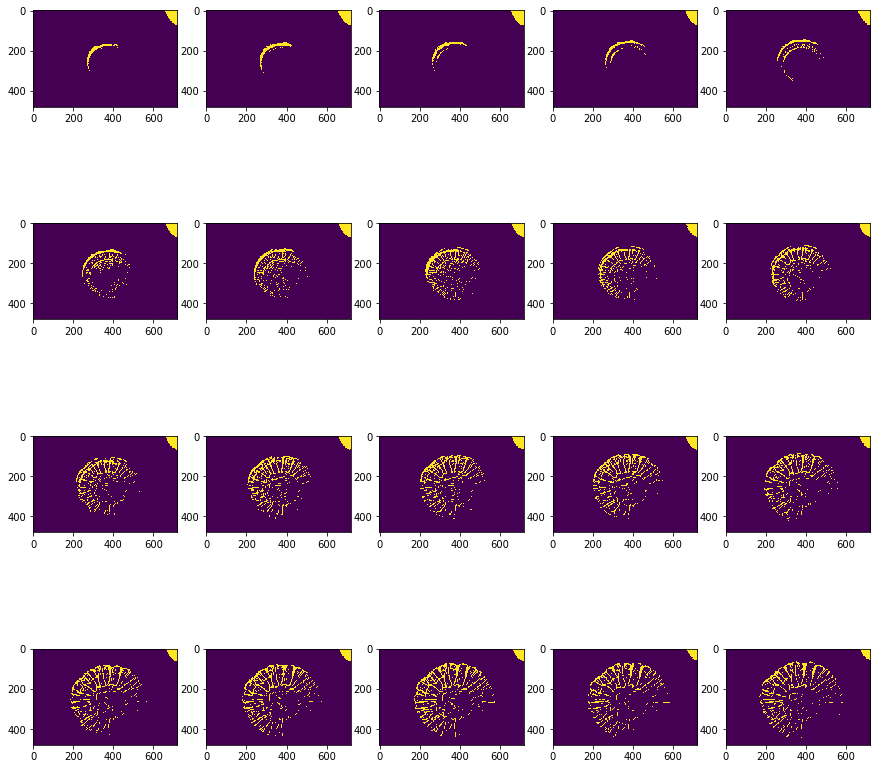

In [31]:
frames = np.arange(0, frameCount, int(281/20))[:20]
f, axarr = plt.subplots(4, 5, figsize=(15,15))
k=0
for i in range(4):
    for j in range(5):
        labels, classes = get_classes(X[frames[k]], n_clusters = 2, movie=True)
        axarr[i,j].imshow(classes)
        k+=1
        
plt.savefig('wrinkle_over_time.png')

### plot percent wrinkle over time



In [22]:
# Create a trace
trace = go.Scatter(
    x = np.arange(len(percent_wrinkle)),
    y = percent_wrinkle
)

data = [trace]

# Edit the layout
layout = dict(title = 'Percent wrinkled area over time',
              xaxis = dict(title = 'Frame'),
              yaxis = dict(title = 'Percent wrinkled area (%)'),
              )

fig = dict(data=data, layout=layout)
iplot(fig)

### Save movie

*** Requires installation of ffmpeg

    - Naivate to frames folder
    - Run shell command below. In future could run shell command from python
    $ ffmpeg -start_number 1 -i frame%d.jpg -vcodec mpeg4 ../test.avi




In [25]:
# file_name = 'new_movie.avi'

# command = 'ffmpeg -start_number 1 -i frame%d.jpg -vcodec mpeg4 ../{}'.format(file_name)

# subprocess.call(command, cwd='video/frames')

In [67]:
# image_folder = 'video/frames'om
# video_name = 'video.avi'

# images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
# frame = cv2.imread(os.path.join(image_folder, images[0]))
# height, width, layers = frame.shape

# # size = (int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
# fourcc = cv2.VideoWriter_fourcc(*'DIVX')  # 'x264' doesn't work
# # out = cv2.VideoWriter('./videos/001_output.mp4',fourcc, 29.0, size, False)  # 'False' for 1-ch instead of 3-ch for color

# video = cv2.VideoWriter(video_name, fourcc, 29.0, (width,height), False)
# # video = cv2.VideoWriter(video_name, -1, 1, (width,height))

# for image in images:
#     video.write(cv2.imread(os.path.join(image_folder, image)))

# cv2.destroyAllWindows()
# video.release()

In [9]:
# img1 = cv2.imread('phz_170725_D3.jpg')

# height , width , layers =  img1.shape

# video = cv2.VideoWriter('video.avi',-1,1,(width,height))

# video.write(img1)
# video.write(img1)
# video.write(img1)
    
# cv2.destroyAllWindows()
# video.release()